In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install scikeras
!pip install --upgrade dask dask_ml distributed

In [4]:
import os
import imageio
import distributed

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from tensorflow import keras
from tensorflow.keras import layers

import dask
import dask.array as da
from dask.distributed import Client

# Initialize the Dask client
client = Client()

In [5]:
# Read in data

tif_lst = os.listdir('/content/gdrive/MyDrive/tif_data/2021')

array_lst = []
for year in os.listdir('/content/gdrive/MyDrive/tif_data'):
    if year != '.DS_Store':
        lazy_raster_lst = [dask.delayed(imageio.imread)('/content/gdrive/MyDrive/tif_data/' + year + '/' + tif) for tif in tif_lst]
        raster_lst = [da.from_delayed(lazy_raster, shape=(40,40), dtype='int32') for lazy_raster in lazy_raster_lst]
        raster_array = da.stack(raster_lst, axis=0)
        array_lst.append(raster_array)
    raw_dataset = da.stack(array_lst, axis=1)

In [6]:
# One-hot encode the data

# This expands the number of channels for each raster from one to three

# The first channel is equal to 1 if data is missing, 0 otherwise
# The second channel is equal to 1 if no deforestation occurred, 0 otherwise
# The third channel is equal to 1 if deforestation occurred, 0 otherwise

dataset = (da.array([-1, 0, 1]) == da.stack([raw_dataset], axis=-1)).astype('int32')

In [7]:
# Get the size of the dataset

print('Dataset size:', dataset.shape)

num_samples = dataset.shape[0]
print('Number of rasters per year:', num_samples)

num_frames = dataset.shape[1]
print('Number of years:', num_frames)

raster_size = dataset.shape[2:]
print('Raster size:', raster_size)

Dataset size: (20, 18, 40, 40, 3)
Number of rasters per year: 20
Number of years: 18
Raster size: (40, 40, 3)


In [8]:
# Split into train and test sets (use indexing to optimize memory)
train_prop = 0.9
sample_indices = da.arange(dataset.shape[0])
da.random.seed(123)
da.random.permutation(sample_indices)
train_indices = sample_indices[:int(train_prop * dataset.shape[0])]
test_indices = sample_indices[int(train_prop * dataset.shape[0]):]
train_dataset = dataset[train_indices]
test_dataset = dataset[test_indices]

In [9]:
# Extract features and outcome variable
# x is frames 0 to n-1, and y is frames 1 to n

def split_x_y(data):
    x = data[:, 0:data.shape[1]-1, :, :]
    y = data[:, 1:data.shape[1], :, :]
    return x, y

x_train, y_train = split_x_y(train_dataset)
x_test, y_test = split_x_y(test_dataset)

In [10]:
# Get the size of the training and test sets

print("Training Feature Shape: " + str(x_train.shape) + 
      ", Training Outcome Shape: " + str(y_train.shape))
print("Testing Feature Shape: " + str(x_test.shape) + 
      ", Testing Outcome Shape: " + str(y_test.shape))

Training Feature Shape: (18, 17, 40, 40, 3), Training Outcome Shape: (18, 17, 40, 40, 3)
Testing Feature Shape: (2, 17, 40, 40, 3), Testing Outcome Shape: (2, 17, 40, 40, 3)


In [12]:
# Define hyperparameters (we can cross-validate these later)

epochs = 50
batch_size = 8
num_filters = 64

In [13]:
# Define the CNN-LSTM architecture

inp = layers.Input(shape=(None, *x_train.shape[2:]))

# Construct three ConvLSTM2D layers with batch norm,
# followed by a Conv3D layer so that the output is
# the same shape as the original raster
x = layers.ConvLSTM2D(filters=num_filters,
                      kernel_size=(5, 5),
                      padding="same",
                      return_sequences=True,
                      activation="relu",)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=num_filters,
                      kernel_size=(3, 3),
                      padding="same",
                      return_sequences=True,
                      activation="relu",)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=num_filters,
                      kernel_size=(1, 1),
                      padding="same",
                      return_sequences=True,
                      activation="relu",)(x)
x = layers.Conv3D(filters=3, 
                  kernel_size=(3, 3, 3), 
                  activation="softmax", 
                  padding="same")(x)

# Build and compile the model
model = keras.models.Model(inp, x)
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam())

In [14]:
# Train the model

# Define callbacks to improve training
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Fit the model to the training data
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping, reduce_lr],)

3/3 [==============================] - 135s 35s/step - loss: 0.5020 - val_loss: 0.6732 - lr: 0.0010


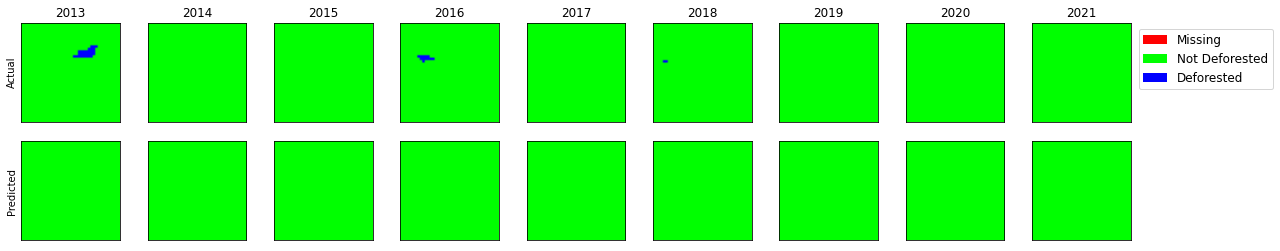

In [16]:
# Visualize results

import numpy as np # the model returns a prediction as a numpy array

# Select a single, random raster from the test set
example = test_dataset[da.random.choice(range(len(test_dataset)), size=1)[0]]

# Split the frames into two parts
idx = example.shape[0] // 2
frames = example[:idx, ...]
original_frames = example[idx:, ...]

# Predict a new set of frames
for _ in range(idx):
    # Extract the model's prediction and post-process it.
    new_prediction_probs = model.predict(da.stack([frames], axis=0))
    new_prediction_probs = np.squeeze(new_prediction_probs, axis=0)
    predicted_frame_probs = np.expand_dims(new_prediction_probs[-1, ...], axis=0)
    predicted_frame = np.eye(predicted_frame_probs.shape[3]) \
      [predicted_frame_probs.argmax(axis=3)] # convert probablities to 0s and 1s
    # Extend the set of prediction frames
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure to plot the original and predicted frames
fig, axes = plt.subplots(2, idx, figsize=(20, 4))

# Plot the original frames
for i, ax in enumerate(axes[0]):
    ax.imshow(da.squeeze(original_frames[i]).astype('float64'), cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(f"{2013 + i}")
    if i == (idx - 1):
        legend = [Patch(facecolor='red', label='Missing'),
                  Patch(facecolor='lime', label='Not Deforested'),
                  Patch(facecolor='blue', label='Deforested')]
        ax.legend(handles=legend, bbox_to_anchor=(2.5, 1), fontsize=12)
    if i==0:
        ax.set_ylabel("Actual")

# Plot the predicted frames
new_frames = frames[idx:, ...]
for i, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[i]), cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
    if i==0:
        ax.set_ylabel("Predicted")

# Display the figure
plt.show()